In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader
from albumentations.pytorch.transforms import ToTensorV2
from tqdm.notebook import tqdm
import albumentations as A

# from ipywidgets import IntProgress
import multiprocessing
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device
import seaborn as sns

from torchvision.ops import batched_nms
import mmcv

from ensemble_boxes import *

from matplotlib.pyplot import imshow
from PIL import Image

from torchvision.ops import box_iou

In [2]:
def plot_image(img_path, boxes, labels):
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    image = image.astype('float32')
    
    categories = [
        { 'id':0, 'name': 'Aortic enlargement'},
        { 'id':1, 'name': 'Atelectasis'},
        { 'id':2, 'name': 'Calcification'},
        { 'id':3, 'name': 'Cardiomegaly'},
        { 'id':4, 'name': 'Consolidation'},
        { 'id':5, 'name': 'ILD'},
        { 'id':6, 'name': 'Infiltration'},
        { 'id':7, 'name': 'Lung Opacity'},
        { 'id':8, 'name': 'Nodule/Mass'},
        { 'id':9, 'name': 'Other lesion'},
        { 'id':10, 'name': 'Pleural effusion'},
        { 'id':11, 'name': 'Pleural thickening'},
        { 'id':12, 'name': 'Pneumothorax'},
        { 'id':13, 'name': 'Pulmonary fibrosis'},
        { 'id':14, 'name': 'No finding'},
    ] 
    
    plt.figure(figsize=(16,16))
    
    for box,label in zip(boxes, labels):
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (225,0,0), 4)
        label = categories[label]['name'].upper()
        print(label, box)
        cv2.putText(image, 
                    label,
                    (box[0], box[1]), 
                    fontFace = cv2.FONT_HERSHEY_COMPLEX, 
                    fontScale = 1,
                    color = (255, 0, 0),
                    thickness = 2,
                    lineType = cv2.LINE_AA
                   )
    plt.imshow(image)

In [10]:
dub_df = pd.read_csv('train.csv')
dub_df = dub_df[dub_df.class_id != 14]
print(len(dub_df))
full_dub_df = dub_df.groupby('image_id').agg(lambda x: list(x)).reset_index()

meta = pd.read_csv('train_meta.csv').set_index('image_id')


36096


In [13]:
def remove_dublicates(df, output_file):
 
    n = len(df)
   
    df_annotations = []

    iou_thr = 0.4
    skip_box_thr = 0.0001

    for idx in tqdm(range(n)):

        records = df.loc[idx]
        image_id = records['image_id']

        width = meta.loc[image_id]['dim1']
        height = meta.loc[image_id]['dim0']
        
        labels = records['class_id']
        scores = np.ones(len(labels))
        
        boxes = records[['x_min','y_min', 'x_max', 'y_max']].to_numpy()
        boxes = np.array(boxes.tolist()).T
        boxes = boxes.astype(int)
        
        boxes = boxes.astype(float)
        boxes[:, 0] = boxes[:, 0] / width
        boxes[:, 2] = boxes[:, 2] / width
        boxes[:, 1] = boxes[:, 1] / height
        boxes[:, 3] = boxes[:, 3] / height

        scores = np.ones(len(labels))

#         filtering dublicates from multiple radiologists 
        boxes, scores, labels = weighted_boxes_fusion([boxes], [scores], [labels], weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)

        boxes[:, 0] = boxes[:, 0] * width
        boxes[:, 2] = boxes[:, 2] * width
        boxes[:, 1] = boxes[:, 1] * height
        boxes[:, 3] = boxes[:, 3] * height
        
        boxes = boxes.astype(int)
        
        labels = labels.astype(int)
        
#         img_path = 'train_2x/train/' + image_id + '.jpg'
#         print(image_id)
#         plot_image(img_path, boxes, labels, scores)

        for i in range(len(boxes)):

            label = labels[i]

            bbox = boxes[i]
            area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
                
            box_anno = dict(
                image_id=image_id,
                class_id=label,
                x_min=bbox[0],
                y_min=bbox[1],
                x_max=bbox[2],
                y_max=bbox[3],
                area=area,
                width=width,
                height=height)

            df_annotations.append(box_anno)
            
    d = pd.DataFrame(df_annotations)
    d.to_csv(output_file, index=False)
            

remove_dublicates(full_dub_df, 'dedub_wbf.csv')

  0%|          | 0/4394 [00:00<?, ?it/s]

In [21]:
# df = pd.read_csv('5_fold_dedub_abnormal_org_size.csv')
df = pd.read_csv('dedub_wbf.csv')


# fold_id = 4
# meta = pd.read_csv('train_meta.csv').set_index('image_id')

# train_df = df[df.fold_id != fold_id].groupby('image_id').agg(lambda x: list(x)).reset_index()
# valid_df = df[df.fold_id == fold_id].groupby('image_id').agg(lambda x: list(x)).reset_index()
full_df = df.groupby('image_id').agg(lambda x: list(x)).reset_index()
# ax = sns.countplot(x="class_id",data=df)

In [22]:
def iou_score(a, b):
    
    w_1 = a[2]-a[0]
    h_1 = a[3]-a[1]

    w_2 = b[2]-b[0]
    h_2 = b[3]-b[1]
    
    a_1 = w_1*h_1
    a_2 = w_2*h_2
    
    xx1 = np.maximum(a[0], b[0])
    yy1 = np.maximum(a[1], b[1])
    xx2 = np.minimum(a[2], b[2])
    yy2 = np.minimum(a[3], b[3])

    w = np.maximum(0.0, xx2 - xx1)
    h = np.maximum(0.0, yy2 - yy1)
    inter = w * h
    ovr = inter / (a_1 + a_2 - inter)

    return ovr

In [23]:
def add_decision(dm, a,b,d):
    dm[a,b] = d
    dm[b,a] = d
    
def vote(dm, j):
    for i in range(14):
    
        if dm[j, i] == -1:
            add_decision(dm, j, i, j)

dm = np.zeros((14,14))
dm.fill(-1)


vote(dm, 0)
vote(dm, 1)
vote(dm, 2)
vote(dm, 12)

  0%|          | 0/4394 [00:00<?, ?it/s]

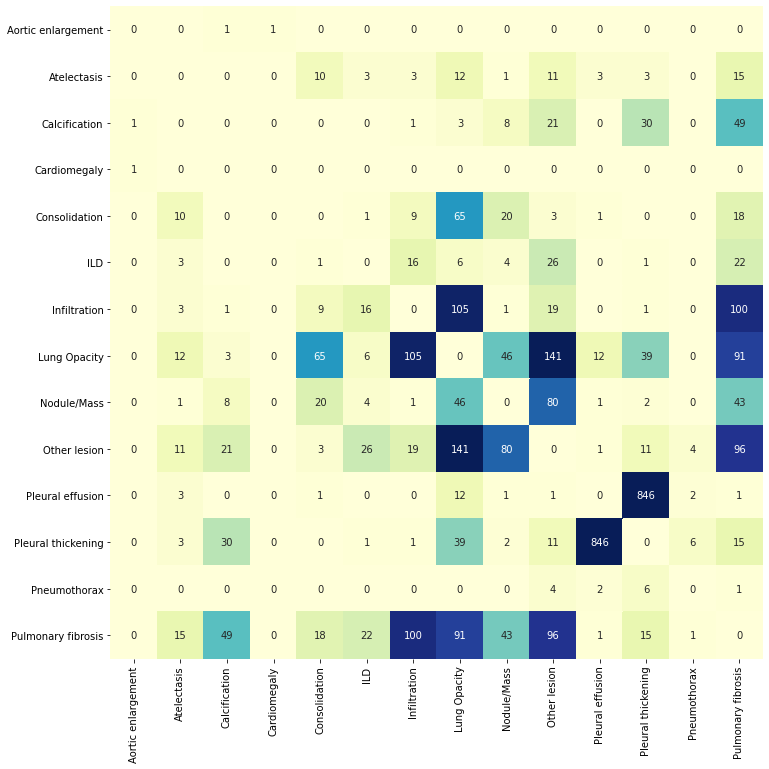

In [24]:
def find_bad_images(df, output_file):
        
    df_annotations = []
        
    n = len(df)
    
    large_thr = 0.8
    iou_thr = 0.95
    
    class_overlap = np.zeros((14,14)).astype(int)
    
    for idx in tqdm(range(n)):

        records = df.loc[idx]
        image_id = records['image_id']

        width = meta.loc[image_id]['dim1']
        height = meta.loc[image_id]['dim0']
        
        labels = np.array(records['class_id'], dtype=int)
        scores = np.ones(len(labels))
        
        boxes = records[['x_min','y_min', 'x_max', 'y_max']].to_numpy()
        boxes = np.array(boxes.tolist()).T
        boxes = boxes.astype(int)

        
        overlaps = np.zeros((len(boxes), len(boxes)))
    
        for i in range(len(boxes)):

            label = labels[i]
            bbox = boxes[i]
            
            w = bbox[2] - bbox[0]
            h = bbox[3] - bbox[1]
            
            box_overlaps = []
            
            for j in range(len(boxes)):
                
                if i != j:
                    iou = iou_score(bbox, boxes[j])
                    
                    if iou >= iou_thr and label != labels[j]:
                        
                        overlaps[i,j] = 1
                        class_overlap[label, labels[j]] += 1
                
                
        overlaps = np.triu(overlaps) 
        checked = {}
        clean = {}
        
        for i in range(len(overlaps)):
             
            if i in checked:
                continue 
            
            row = overlaps[i].flatten()
            overlapping_ids = np.argwhere(row == 1).flatten().tolist()
            
            if len(overlapping_ids) > 0:
                
                overlapping_ids.append(i)
                clean[i] = overlapping_ids

                for box_idx in overlapping_ids:
                    checked[box_idx] = 1
            else:
                clean[i] = [i]
                checked[i] = 1
        
        
        
        for k, v in clean.items():
                
            if len(v) >= 2:
                
                classes_count = []
                
                bbox = boxes[k]
                
                for box_id in v:
                    
                    classes_count.append(freq[labels[box_id]])
                    
                    if labels[box_id] != 9:
                    
                        box_anno = dict(
                            image_id=image_id,
                            class_id=labels[box_id],
                            x_min=bbox[0],
                            y_min=bbox[1],
                            x_max=bbox[2],
                            y_max=bbox[3],
                            width=width,
                            height=height)

                        df_annotations.append(box_anno)    
            
            elif len(v) == 1:
                
                bbox = boxes[v[0]]
                
                box_anno = dict(
                    image_id=image_id,
                    class_id=labels[k],
                    x_min=bbox[0],
                    y_min=bbox[1],
                    x_max=bbox[2],
                    y_max=bbox[3],
                    width=width,
                    height=height)
                
                df_annotations.append(box_anno)
                
    hm = class_overlap

    d = pd.DataFrame(df_annotations)
    d.to_csv(output_file, index=False)
     
    classes = (
    "Aortic enlargement", 
    "Atelectasis", 
    "Calcification", 
    "Cardiomegaly", 
    "Consolidation", 
    "ILD", 
    "Infiltration", 
    "Lung Opacity", 
    "Nodule/Mass", 
    "Other lesion", 
    "Pleural effusion", 
    "Pleural thickening", 
    "Pneumothorax", 
    "Pulmonary fibrosis")

    
    fig, ax = plt.subplots(figsize=(12,12)) 
    f = sns.heatmap(hm, square=True, robust=True, annot=True, cbar=False, xticklabels=classes, yticklabels=classes, fmt="d", cmap="YlGnBu")


freq = np.array([2950,  190,  625, 2220,  379,  599,  806, 1646, 1626, 50000, 1230,
       3195,  106, 2442])
find_bad_images(full_df, 'dedub_wbf_no_lesion.csv')

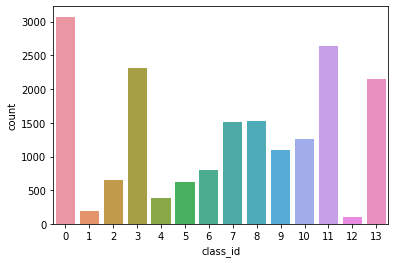

In [186]:
dedub = pd.read_csv('no_lesion.csv')
ax = sns.countplot(x="class_id",data=dedub)
# dedub.class_id.value_counts()

array([2950,  190,  625, 2220,  379,  599,  806, 1646, 1626, 1063, 1230,
       3195,  106, 2442])

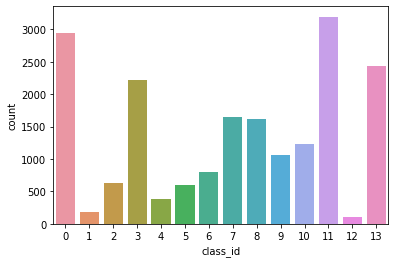

In [220]:
dedub = pd.read_csv('5_fold_multi.csv')
ax = sns.countplot(x="class_id",data=dedub)
d = dict(dedub.class_id.value_counts())

freq = np.zeros(14)

for k, v in d.items():
    freq[k] = v
    
freq.astype(int)

In [76]:
def generate_data_json(df, output_file):
    
    categories = [
        { 'id':0, 'name': 'Aortic enlargement'},
        { 'id':1, 'name': 'Atelectasis'},
        { 'id':2, 'name': 'Calcification'},
        { 'id':3, 'name': 'Cardiomegaly'},
        { 'id':4, 'name': 'Consolidation'},
        { 'id':5, 'name': 'ILD'},
        { 'id':6, 'name': 'Infiltration'},
        { 'id':7, 'name': 'Lung Opacity'},
        { 'id':8, 'name': 'Nodule/Mass'},
        { 'id':9, 'name': 'Other lesion'},
        { 'id':10, 'name': 'Pleural effusion'},
        { 'id':11, 'name': 'Pleural thickening'},
        { 'id':12, 'name': 'Pneumothorax'},
        { 'id':13, 'name': 'Pulmonary fibrosis'},
    ] 
    
    n = len(df)

    annotations = []
    images = []
    
    obj_count = 0

    for idx in tqdm(range(n)):

        records = df.loc[idx]
        image_id = records['image_id']
        
        width = meta.loc[image_id]['dim1'] 
        height = meta.loc[image_id]['dim0']
    
        images.append(dict(
            id=idx,
            file_name=image_id + '.jpg',
            height=height,
            width=width))
 
        boxes = records[['x_min','y_min', 'x_max', 'y_max']].to_numpy()
        boxes = np.array(boxes.tolist()).T
        boxes = boxes.astype(int)
        labels = records['class_id']
        
#         for i in len(boxes):
            
#             box_1 = boxes[i]
            
#             for j in len(boxes):
                
#                 box_2 = boxes[j]
                
#                 iou = box_iou(box_1, box_2)

#                 if iou > 0.2 and labels[i] == labels[j]:
#         scores = np.ones(len(labels))
#         img_path = 'vinbigdata/train/' + image_id + '.jpg'
#         plot_image(img_path, boxes, labels)        
          
        for i in range(len(boxes)):

            label = labels[i]
#             print(categories[label])
            bbox = boxes[i]
            area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
            
#             if bbox[2] - bbox[0] > width * 0.6:
#                 continue
            
            data_anno = dict(
                image_id=idx,
                id=obj_count,
                category_id=label,
                bbox=[bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]],
                area=area,
                iscrowd=0)
            
            annotations.append(data_anno)
            
            obj_count += 1
    
    coco_format_json = dict(
        images=images,
        annotations=annotations,
        categories=categories)
    mmcv.dump(coco_format_json, output_file)

In [82]:
generate_data_json(train_df, 'fold_0_abnormal_train_org_size.json')

  0%|          | 0/3959 [00:00<?, ?it/s]

In [83]:
generate_data_json(valid_df, 'fold_0_abnormal_valid_org_size.json')

  0%|          | 0/435 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1319
5
LUNG OPACITY [ 170  478 2034 1481]
PLEURAL THICKENING [1184  246 1586  327]
LUNG OPACITY [1184  246 1586  327]
AORTIC ENLARGEMENT [1068  517 1350  768]
PULMONARY FIBROSIS [1355  616 1700 1177]
PLEURAL THICKENING [469 303 781 368]
OTHER LESION [  43    0  882 1435]
OTHER LESION [2091 1171 2268 1816]
OTHER LESION [345  18 728 316]
OTHER LESION [2093 1200 2123 1244]
OTHER LESION [1182    1 2100 1483]
OTHER LESION [  10 1449   68 1687]
OTHER LESION [1285    0 1730  244]
OTHER LESION [ 329    0 1777  291]
OTHER LESION [  72 2076  162 2431]
000d68e42b71d3eac10ccc077aba07c1


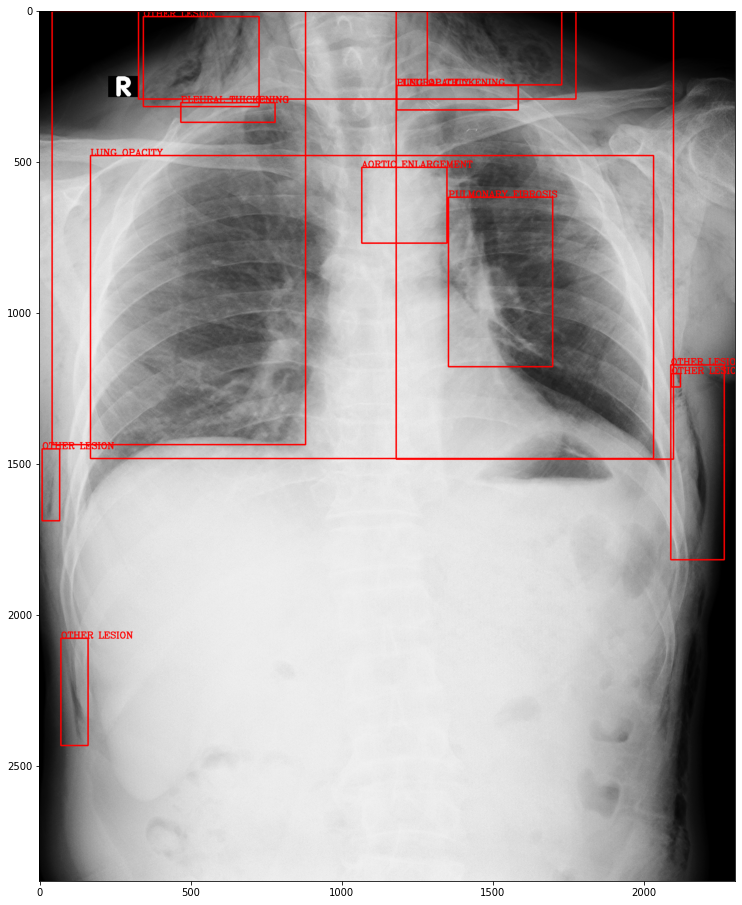

In [19]:
bad = pd.read_csv('bad.csv')


df = pd.read_csv('dedub_wbf_no_lesion.csv').groupby('image_id').agg(lambda x: list(x)).reset_index()
df = df.set_index('image_id')

print(len(bad.groupby('image_id')))
print(len(bad[bad.type == 'large']))
idx = 2

image_id = bad.loc[idx - 1]['image_id']
# image_id = '0005e8e3701dfb1dd93d53e2ff537b6e'

records = df.loc[image_id]

img_path = 'vinbigdata/images/train/' + image_id + '.jpg'


boxes = records[['x_min','y_min', 'x_max', 'y_max']].to_numpy()
boxes = np.array(boxes.tolist()).T
labels = records['class_id']
scores = np.ones(len(labels))

plot_image(img_path, boxes, labels)
print(image_id)

In [42]:
test_df = pd.read_csv('test.csv')
categories = [
    { 'id':0, 'name': 'Aortic enlargement'},
    { 'id':1, 'name': 'Atelectasis'},
    { 'id':2, 'name': 'Calcification'},
    { 'id':3, 'name': 'Cardiomegaly'},
    { 'id':4, 'name': 'Consolidation'},
    { 'id':5, 'name': 'ILD'},
    { 'id':6, 'name': 'Infiltration'},
    { 'id':7, 'name': 'Lung Opacity'},
    { 'id':8, 'name': 'Nodule/Mass'},
    { 'id':9, 'name': 'Other lesion'},
    { 'id':10, 'name': 'Pleural effusion'},
    { 'id':11, 'name': 'Pleural thickening'},
    { 'id':12, 'name': 'Pneumothorax'},
    { 'id':13, 'name': 'Pulmonary fibrosis'},
] 
images = []
for i in range(len(test_df)):
    r = test_df.iloc[i]
    image_id = r['image_id']
    images.append(dict(
        id=i,
        file_name=image_id + '.jpg',
        height=r['height'],
        width=r['width']))
coco_format_json = dict(
    images=images,
    categories=categories)
mmcv.dump(coco_format_json, 'test_coco_org.json')

In [1]:
%load_ext tensorboard

In [5]:
%tensorboard --logdir checkpoints_1024_fold_0/tf_logs --port=6008

Reusing TensorBoard on port 6008 (pid 700), started 0:00:12 ago. (Use '!kill 700' to kill it.)